In [1]:
# path operations
from glob import glob
import os
from pathlib import Path

# data format and storage
from collections import namedtuple
import pickle

# numerical tools
import numpy as np
import scipy.stats
import pandas as pd

# plotting tools
from matplotlib import pyplot as plt
# %matplotlib notebook

# interactive notebook features
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact

# meg analysis
import mne

## Find all available subjects

Define where you store your `camcan` data in the variable `camcanroot`.

In [2]:
camcanroot = Path('/Volumes') / 'Seagate Expansion Drive' /'camcan'
# camcanroot = Path('D:') / 'camcan'
# camcanroot = Path('/data') / 'group' / 'FANS' / 'camcan-meg' / 'camcan165' / 'camcan165'
# camcanroot = Path('/Users') / 'jan' / 'Documents' / 'eeg-data' / 'camcan'

megdataroot = camcanroot / 'cc700' / 'mri' / 'pipeline' / 'release004' / 'BIDSsep' / 'megraw'
subjects = list(megdataroot.glob('sub-*'))
ids = [os.path.split(subject)[-1][4:] for subject in subjects]

print(f'{len(subjects)} subjects found in {megdataroot}')

647 subjects found in /Volumes/Seagate Expansion Drive/camcan/cc700/mri/pipeline/release004/BIDSsep/megraw


In [3]:
# filter out no-files
subjects = [subject for subject in subjects if (subject / 'meg' / 'rest_raw.fif').is_file()]
print(f'{len(subjects)} subjects have resting-state recordings.')

647 subjects have resting-state recordings.


## Find the demographic information

Read the demographic information from the .tsv file provided.

In [4]:
subject_details = pd.DataFrame.from_csv(camcanroot / 'cc700-scored' / 'participant_data.csv')
print(f'Found subject information on {len([pid for pid in ids if pid in subject_details.index])} subjects.')

Found subject information on 647 subjects.


## Set up MEG analysis variables

In [5]:
veog = 'EOG062'
heog = 'EOG061'
ecg = 'ECG063'

## Loop over MEG data

First, make a data structure we can put the data in

In [6]:
sub_params = namedtuple('sub_params',
                        ['pid', 'slopes', 'age', 'gender',
                         'intercepts', 'rsquared'])

For the pre-processing, we'll also use Maxwell-filtering to correct for extraneous influence. These are the necessary files:

In [7]:
ctfile = megdataroot / 'ct_sparse.fif'
ssscal = megdataroot / 'sss_cal.dat'

In [8]:
# split the data into sequential segments for RANSAC method
# starts = np.arange(0, (raw.n_times-raw.info['sfreq']*5)/10, raw.info['sfreq']*5)
# events = np.stack(
#     [starts,
#      starts + raw.info['sfreq']*5,
#      np.ones_like(starts)]
# ).T.astype('int')

# sequential_epochs = mne.Epochs(raw, events=events, event_id=1,
#                                picks=mne.pick_types(raw.info, meg='grad'), preload=True, proj=False)

# ransac = Ransac(verbose='tqdm_notebook', n_jobs=1)
# epochs_clean = ransac.fit_transform(sequential_epochs)


In [9]:
# # get the EOG data, filter it
# eog_data, t = raw[mne.pick_types(raw.info, eog=True, meg=False)]
# eog_data_filtered = mne.filter.filter_data(eog_data, raw.info['sfreq'], 1, 15)
# # only take vertical for now
# eog_data_filtered = eog_data_filtered[1, :]

# # get the ECG data, filter it
# ecg_data, t = raw[mne.pick_types(raw.info, ecg=True, meg=False)]
# ecg_data_filtered = mne.filter.filter_data(ecg_data, raw.info['sfreq'], 0.5, 15)

# # try the automated ICA
# picks = mne.pick_types(raw.info, meg='grad')
# ica_comps = mne.preprocessing.run_ica(
#     raw, 63, max_pca_components=63,
#     picks=np.random.choice(picks, 64, replace=False), eog_ch=eog_data_filtered, ecg_ch=ecg_data_filtered
# )

In [10]:
# raw = mne.io.read_raw_fif(subjects[0] / 'meg' / 'rest_raw.fif', verbose='WARNING')

# # make a bandpass-filtered ecg channel


# raw_corrected = mne.preprocessing.maxwell_filter(raw, cross_talk=str(ctfile), calibration=str(ssscal),
#                                                  st_duration=10, st_correlation=0.98)

# raw.plot_psd(tmax=600, fmax=60, average=False, spatial_colors=True)
# raw_corrected.plot_psd(tmax=600, fmax=60, average=False, spatial_colors=True)

Then, populate this data structure for each subject

In [11]:
all_parameters = []
psds = []

for subject in tqdm(range(2)):
    # resting state file
    restfile = subjects[subject] / 'meg' / 'rest_raw.fif'
    # raw data
    raw = mne.io.read_raw_fif(restfile, verbose='WARNING')
    # crop
    raw = raw.crop(tmin=1, tmax=120)
    # resample
    raw = raw.load_data()
    raw = raw.resample(256)
    # filter
    # filter the MEG data (exclude line noise)
    raw = raw.filter(0.5, 30, picks=mne.pick_types(raw.info, meg=True))
    # filter the EOG data
    raw = raw.filter(0.5, 15, picks=mne.pick_types(raw.info, meg=False, eog=True))
    # filter the ECG data
    raw = raw.filter(0.5, 15, picks=mne.pick_types(raw.info, meg=False, ecg=True))
    # maxwell-correction
#     raw = mne.preprocessing.maxwell_filter(raw, cross_talk=str(ctfile), calibration=str(ssscal),
#                                            st_duration=10, st_correlation=0.98)
    # pick gradiometers
    picks = mne.pick_types(raw.info, meg='grad', eeg=False, stim=False, eog=False, exclude='bads')
    # run an ICA
    ica = mne.preprocessing.run_ica(raw, n_components=0.95,
                                    picks=picks,
                                    eog_ch=veog, ecg_ch=ecg)
    unprocessed_raw = raw.copy()
    # apply this ICA
    raw = ica.apply(raw, exclude=ica.exclude)
    
    # do the PSD analysis
    psd, freqs = mne.time_frequency.psd_welch(
        raw, picks=picks, fmin=2, fmax=24, tmin=1, tmax=601, n_fft=2000, n_overlap=1000,
        verbose='WARNING', n_jobs=4
    )
    # Do the linear regression
    findices = (freqs < 7) | (freqs > 14)
    linfits = [scipy.stats.linregress(freqs[findices], np.log10(psd.T[findices, grad]))
               for grad in range(psd.shape[0])]

    psds.append(psd)
    all_parameters.append(
        sub_params(pid=ids[subject],
                   slopes=np.array([l.slope for l in linfits]),
                   intercepts=np.array([l.intercept for l in linfits]),
                   rsquared=np.array([l.rvalue**2 for l in linfits]),
                   age=subject_details.loc[ids[subject]].age,
                   gender=subject_details.loc[ids[subject]].gender_code)
    )



Fitting ICA to data using 204 channels. 
Please be patient, this may take some time
Selection by explained variance: 93 components


/Library/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


<ICA  |  raw data decomposition, fit (fastica): 30464 samples, 93 components, channels used: "grad">
    Now searching for artifacts...
    found 1 artifact by ECG
    found 9 artifacts by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    54, 26, 37, 50, 56, 57, 63, 67, 80, 84, 64, 64, 33
    Removing duplicate indices...
Ready.
Transforming to ICA space (93 components)
Zeroing out 12 ICA components
Fitting ICA to data using 204 channels. 
Please be patient, this may take some time
Selection by explained variance: 78 components
<ICA  |  raw data decomposition, fit (fastica): 30464 samples, 78 components, channels used: "grad">
    Now searching for artifacts...
    found 3 artifacts by ECG
    found 5 artifacts by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    2, 38, 71, 0, 1, 3, 49, 61, 50, 50, 13
    Removing duplic

### Save data to pickles

In [ ]:
# save data to file
with open('./pickles/psds.pickle', 'wb+') as f:
    pickle.dump(psds, f)
with open('./pickles/all_parameters.pickle', 'wb+') as f:
    pickle.dump(all_parameters, f)


---

### Load data from pickles

In [ ]:
with open('./pickles/psds.pickle', 'rb') as f:
    psds = pickle.load(f)
with open('./pickles/all_parameters.pickle', 'rb') as f:
    all_parameters = pickle.load(f)

---

## Identify outlier electrodes

In [12]:
bad_elecs = []

for pid in range(len(psds)):
    bads = np.zeros_like(all_parameters[pid].rsquared, dtype='bool')
    bads = bads | (all_parameters[pid].slopes > 0)
    bads = bads | (all_parameters[pid].intercepts >
                   all_parameters[pid].intercepts.mean() + 2 * all_parameters[pid].intercepts.std())
    bads = bads | (all_parameters[pid].intercepts <
                   all_parameters[pid].intercepts.mean() - 2 * all_parameters[pid].intercepts.std())
    bad_elecs.append(bads)

### Average power-spectrum

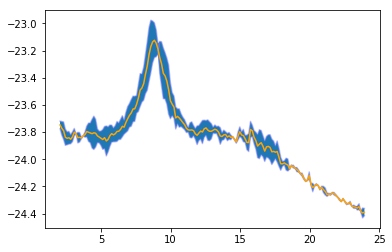

In [13]:
pltdata = np.log10(np.stack([p[~bad_elecs[i], :].mean(axis=0)
                             for i, p in enumerate(psds)],
                            axis=-1))

x = list(range(pltdata.shape[0]))
x = freqs

plt.figure()
plt.fill_between(x,
                 np.mean(pltdata, axis=-1)-scipy.stats.sem(pltdata, axis=-1),
                 np.mean(pltdata, axis=-1)+scipy.stats.sem(pltdata, axis=-1))
plt.plot(x, pltdata, color=(0.5, 0.5, 1, 0.5))
plt.plot(x, np.mean(pltdata, axis=-1), color='orange')
plt.show()

### Individual power spectrums

In [14]:
def individual_spectrum(subjectno):
    dat = psds[subjectno]
    plt.figure()
    # plot individual lines, faint
    plt.plot(freqs, np.log10(dat.T), color=(0.3, 0.3, 1.0, 0.2))
    plt.plot(freqs, np.log10(dat).mean(axis=0), color=(1, 0.3, 0.3))
    plt.show()

interact(individual_spectrum, subjectno=(0, len(psds)-1))

<function __main__.individual_spectrum>

### Boxplot of regression slope and average $r^2$ across electrodes for each subject

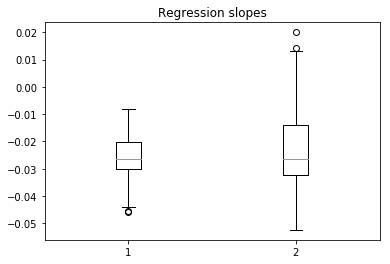

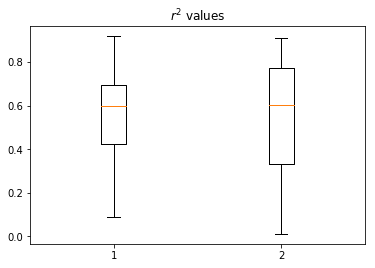

In [15]:
y = np.array([p.slopes for p in all_parameters])

plt.figure()
plt.boxplot(y.T)
plt.title('Regression slopes')
plt.show()

y = np.array([p.rsquared for p in all_parameters])

plt.figure()
plt.boxplot(y.T)
plt.title('$r^2$ values')
plt.show()


### Scatter plot of age vs 1/f noise

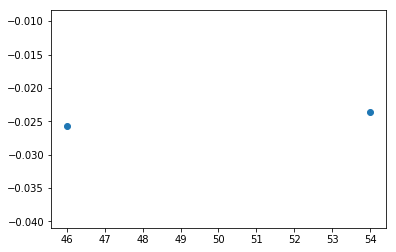

In [16]:
x = [p.age for p in all_parameters]
y = [np.mean(p.slopes) for p in all_parameters]

plt.figure()
plt.scatter(x, y)
plt.show()